# **Clase 20 - Large Language Models**

MDS7202: Laboratorio de Programación Científica para Ciencia de Datos

## **Objetivos**

- Conocer qué son los LLM y cómo trabajarlos con LangChain
- Aprender a generar chains de prompts
- Comprender el paradigma de Agentes
- Entender como generar una solución RAG
- Introducir al estudiante a soluciones multiagente

## **Configuración Inicial 🧐**

Para esta clase necesitaremos configurar las credenciales de algunos servicios a utilizar, en específico:

### **Google AI Studio**

Usaremos `Google AI Studio` para habilitar el uso de LLMs y Embeddings de Google. Simplemente deben registrarse con su cuenta google y obtener su API KEY desde el siguiente enlace: [Google AI Studio](https://aistudio.google.com/app/u/1/apikey).

### **Tavily**

En paralelo, utilizaremos `Tavily` como motor de búsqueda para potenciar las respuestas de nuestros agentes. Tal como en el paso anterior, solo deben registrarse y obtener su API KEY desde el siguiente enlace: [Tavily](https://tavily.com/).

### **Configurar credenciales en ambiente**

Una vez se tienen todas las credenciales, pasamos a activarlas en nuestro ambiente local por medio del siguiente código:

In [1]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

O si les sale más fácil, también pueden hacerlo a través de un archivo **.env** (esto funciona mejor cuando trabajan desde sus máquinas locales).

Sólo debemos crearlo y escribir en él todas las credenciales:

```python
GOOGLE_API_KEY="<YOUR_GOOGLE_API_KEY>"
TAVILY_API_KEY="<YOUR_TAVILY_API_KEY>”
```

Luego, cargamos las credenciales al ambiente:

In [2]:
%pip install --upgrade --quiet python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from dotenv import load_dotenv

load_dotenv() # cargar las variables guardadas en el archivo .env

False

## **¿Qué son los Large Language Models? 🤔**

Los **Large Language Models (LLM)** son modelos de lenguaje basados en **redes neuronales del tipo transformer** entrenados con una gran cantidad de texto. Estos modelos poseen las siguientes características distintivas:

- Son modelos **entrenados con grandes volúmenes de lenguaje** (corpus del tamaño de internet), permitiéndoles aprender patrones complejos del lenguaje y obtener una comprensión semántica profunda.

- Son modelos con una **gran cantidad de parámetros** (miles de millones!), lo que les permite captar sutilezas lingüísticas, estilo y tono en un nivel sin precedentes.

Adicionalmente, existen 2 grandes tipos de LLM:

- Modelos basados en **representaciones**: Son modelos orientados a **aprender representaciones** (o *embeddings*) del lenguaje. Un ejemplo notable de este tipo de modelos es [BERT](https://arxiv.org/abs/1810.04805).
- Modelos basados en **completion**: Son modelos diseñados para **predecir la siguiente palabra** de un texto. Un ejemplo notable son los modelos GPT (Generative Pre-trained Transformers), como GPT3.5 o GPT4.

De estos modelos, son los GPT los que han obtenido más fama en el último tiempo, dando pie a una gran cantidad de soluciones basadas en esta tecnología.
Como podrán suponer, para esta clase nos concentraremos en los LLM de completion.

> **Pregunta**: ¿Por qué creen que que los GPT basados en completion tuvo mayor éxito?

<center>
<img src='https://media4.giphy.com/media/qAtZM2gvjWhPjmclZE/giphy.gif' width=450  />
</center>



## **LangChain 🦜**

`LangChain` es un framework de código abierto diseñado para desarrollar aplicaciones basadas en LLM. Basa su funcionamiento en los siguientes componentes:

<center>
<img src='https://raw.githubusercontent.com/MDS7202/MDS7202/main/recursos/2024-01//LLM/langchain.png' width=450  />
</center>

**1. Prompts y Plantillas de Prompts**: Los prompts son consultas que enviamos a los LLMs, y su calidad impacta las respuestas. LangChain facilita la creación y gestión de prompts mediante plantillas que combinan instrucciones, contenido y consultas.

```python
template = """
You are required to answer the following question in form of bullet points based on the provided context.
The answer should be answer as a doctor and your language is spanish.:
{context}
Now based on above context answer the following question:
{question}

Answer:
"""
```

**2. Modelos**: LangChain no incluye LLMs, pero permite integrar fácilmente varios modelos de lenguaje (como GPT-3, BLOOM), de chat (como GPT-3.5-turbo) y de embedding de texto (de CohereAI, HuggingFace y OpenAI) mediante un simple framework donde solo necesitas la API Key o cargar el modelo en memoria.

```python
from langchain.llms import OpenAI

openai = OpenAI(
   openai_api_key=”YOUR OPEN AI API KEY”,
   model_name="gpt-3.5-turbo-16k",
)
```

**3. Output Parsers**: Los output parsers permiten ajustar la salida de un LLM a un formato específico, ya sea a una cantidad limitada de posibles outputs o otro tipo de formato (int, float, json, list, etc.). Esto permite que un programa haga algo con la salida, como tomar una decisión.

```python
from pydantic import BaseModel, Field
from typing import Literal

class QuestionSentiment(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(
        description="Sentiment that the question of the user has"
    )
```

**4. Chains**: LangChain permite crear flujos de trabajo, o "chains," que son secuencias de llamadas a modelos de lenguaje o a herramientas externas. Estos flujos pueden incluir varias etapas de procesamiento, donde la salida de una etapa se convierte en la entrada de la siguiente. son el simil de pipelines de `scikit-learn`.

```python
chain = prompt | llm | StrOutputParser()
```

**5. Memoria**: Por defecto, las cadenas en LangChain son sin estado, es decir, no guarda un registro de las interacciones anteriores hechas con el modelo. Para superar esto, LangChain nos asiste con *buffers* para almacenar de forma iterativa las interacciones realizadas.

<center>
<img src='https://raw.githubusercontent.com/MDS7202/MDS7202/main/recursos/2024-01//LLM/memory.png' width=600 />
</center>

**6. Agentes**: Los agentes en LangChain toman decisiones sobre acciones según la entrada o el estado del flujo, como buscar información o llamar a una API, lo que permite crear aplicaciones interactivas y adaptables.

<center>
<img src='https://raw.githubusercontent.com/MDS7202/MDS7202/main/recursos/2024-01//LLM/agents.png' width=450  />
</center>

## **Manos a la Obra! 👷‍♂️**

<center>
<img src='https://media1.tenor.com/m/QQNtnfVCfvUAAAAd/baby-scream-yeah.gif' width=350  />
</center>

Ya que conocemos los conceptos básicos de los LLM y LangChain, pasemos ahora a estudiar como implementar estos conceptos en nuestro código. Primero instalamos algunas librerías necesarias:

In [4]:
%pip install --upgrade --quiet  langchain-google-genai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Luego, pasemos a usar un LLM. Para esta clase utilizaremos `gemini-1.5-flash` de `Google`, pero esto lo pueden cambiar a futuro si disponen de diferentes recursos (por ejemplo, por algún modelo de `OpenAI` o `Azure`):

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", # modelo de lenguaje
    temperature=0, # probabilidad de "respuestas creativas"
    max_tokens=None, # sin tope de tokens
    timeout=None, # sin timeout
    max_retries=2, # número máximo de intentos
)

llm

ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), temperature=0.0, max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000021758DA16A0>, default_metadata=(), model_kwargs={})

Con el modelo ya levantado, podemos interactuar con él de la misma forma que lo hacemos con [ChatGPT](https://chatgpt.com/):

In [28]:
question = "hola!"
response = llm.invoke(question) # invoke para interactuar con el modelo
response.content

'¡Hola! ¿En qué puedo ayudarte hoy? 😊'

Podemos mejorar la calidad de las respuestas mediante **prompts**, es decir, entregando instrucciones al modelo para que entregue respuestas de alguna manera específica. Para esto, LangChain nos facilita la opción de crear **templates**, los cuales son **instrucciones pre establecidas** que el modelo deberá seguir para responder una pregunta. Por ejemplo:

In [7]:
from langchain_core.prompts import PromptTemplate

# template: noten como la variable {question} va a ser completada con la pregunta del usuario.
template = '''
Eres un profesional experto en formula 1.
Tu único rol es responder de la forma más completa posible la pregunta del usuario.

Pregunta: {question}
Respuesta útil:
'''

prompt = PromptTemplate.from_template(template)
prompt

PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='\nEres un profesional experto en formula 1.\nTu único rol es responder de la forma más completa posible la pregunta del usuario.\n\nPregunta: {question}\nRespuesta útil:\n')

Noten como nuestro prompt comparte el método `.invoke`:

In [14]:
print(prompt.invoke("hola").text)


Eres un profesional experto en formula 1.
Tu único rol es responder de la forma más completa posible la pregunta del usuario.

Pregunta: hola
Respuesta útil:



Esto pasa porque tanto el `ChatModel` como `PromptTemplate` implementan la interfaz `LCEL` (Langchain Expressión Language). Con esto en consideración, podemos juntar el LLM y el prompt creado!

En `langchain` podemos utilizar el operador `|` para **concatenar** diferentes acciones que queremos que nuestra aplicación realice (a esto se le llama **chains**). En este caso, deseamos que la LLM utilice una plantilla para responder. Esto lo hacemos de la siguiente manera:

In [15]:
chain = prompt | llm # definimos la cadena
response = chain.invoke("hola!") # interactuamos con ella a través de invoke
response

AIMessage(content='¡Hola! ¿En qué puedo ayudarte hoy con respecto a la Fórmula 1? Puedo responder preguntas sobre:\n\n*   **Pilotos:** Trayectoria, estadísticas, rendimiento actual, rivalidades, etc.\n*   **Equipos:** Historia, estructura, rendimiento actual, estrategias, desarrollo del coche, etc.\n*   **Coches:** Diseño, aerodinámica, motor, neumáticos, actualizaciones, etc.\n*   **Reglamento:** Técnico, deportivo, financiero, cambios recientes, etc.\n*   **Circuitos:** Características, récords, historia, desafíos, etc.\n*   **Carreras:** Resultados, análisis, momentos clave, estrategias, etc.\n*   **Historia de la F1:** Campeones, momentos icónicos, evolución del deporte, etc.\n*   **Noticias y rumores:** Últimas novedades, fichajes, predicciones, etc.\n*   **Estrategias de carrera:** Neumáticos, paradas en boxes, gestión de combustible, etc.\n*   **Tecnología:** Innovaciones, impacto en el rendimiento, etc.\n\nDime qué te interesa y haré lo posible por darte la información más comp

In [16]:
print(response.content) # print a la respuesta

¡Hola! ¿En qué puedo ayudarte hoy con respecto a la Fórmula 1? Puedo responder preguntas sobre:

*   **Pilotos:** Trayectoria, estadísticas, rendimiento actual, rivalidades, etc.
*   **Equipos:** Historia, estructura, rendimiento actual, estrategias, desarrollo del coche, etc.
*   **Coches:** Diseño, aerodinámica, motor, neumáticos, actualizaciones, etc.
*   **Reglamento:** Técnico, deportivo, financiero, cambios recientes, etc.
*   **Circuitos:** Características, récords, historia, desafíos, etc.
*   **Carreras:** Resultados, análisis, momentos clave, estrategias, etc.
*   **Historia de la F1:** Campeones, momentos icónicos, evolución del deporte, etc.
*   **Noticias y rumores:** Últimas novedades, fichajes, predicciones, etc.
*   **Estrategias de carrera:** Neumáticos, paradas en boxes, gestión de combustible, etc.
*   **Tecnología:** Innovaciones, impacto en el rendimiento, etc.

Dime qué te interesa y haré lo posible por darte la información más completa y precisa.


Noten como la respuesta del LLM es un `AIMessage`, el cual contiene la respuesta y metadata adicional con respecto al mensaje entregado.

Para recuperar sólo el mensaje, podemos usar `StrOutputParser` en la chain:

In [8]:
from langchain_core.output_parsers import StrOutputParser

chain = prompt | llm | StrOutputParser() # definimos la cadena
response = chain.invoke("quién es el mejor piloto de la formula 1?") # interactuamos con ella a través de invoke
print(response)

Determinar al "mejor piloto de la Fórmula 1" es un debate que nunca tendrá una respuesta definitiva, ya que depende de los criterios que se utilicen y de la subjetividad de cada persona. Sin embargo, puedo ofrecerte un análisis exhaustivo considerando diferentes perspectivas y los argumentos más comunes:

**Criterios para la Evaluación:**

Antes de nombrar candidatos, es crucial definir qué significa ser "el mejor". Algunos criterios clave incluyen:

*   **Número de Campeonatos Mundiales:** Este es el criterio más objetivo y directo. Un mayor número de campeonatos indica consistencia, habilidad y capacidad para rendir bajo presión a lo largo de varias temporadas.
*   **Número de Victorias en Grandes Premios:** Similar a los campeonatos, las victorias demuestran la capacidad de un piloto para superar a sus competidores en carreras individuales.
*   **Número de Poles Positions:** Las poles positions reflejan la velocidad pura y la habilidad del piloto en una sola vuelta.
*   **Consistenc

Similar al caso anterior, también podemos definir **más de una variable** de entrada en nuestro prompt:

In [9]:
from langchain_core.prompts import PromptTemplate

template = '''
Eres un profesional experto en formula 1.
Tu único rol es responder de la forma más completa posible la pregunta del usuario.
Además, debes responder con el idioma que se te indique.

Pregunta: {question}
Idioma: {language}
Respuesta útil:
'''

prompt = PromptTemplate.from_template(template)

chain = prompt | llm
response = chain.invoke({"question": "hola!", "language": "chinese"}) # noten como ahora invoke recibe un diccionario
print(response.content)

你好！很高兴能为您提供一级方程式赛车的专业知识。请随时提出您的问题，我会尽力用中文详细解答。无论您想了解赛车技术、车队策略、车手表现、历史赛事，还是最新的赛事动态，我都将竭诚为您服务。期待您的提问！


## Experimento: Conversación filosófica entre 2 LLM 😱

Ya que conocemos lo básico para interactuar con LLMs a través de código, podemos ejecutar algunos experimentos interesantes. Por ejemplo, **qué pasaría si hacemos que 2 LLM conversen sobre filosofía entre sí?**

Probemos!

<center>
<img src='https://tvquotes.co/wp-content/uploads/2017/09/you-pass-butter.gif' width=400/>
</center>



In [25]:
import time

# instrucciones generales
template = """
Eres un filósofo curioso que busca tanto aprender más como buscar aprendizaje en el otro evocando 
curiosidad y auto-cuestionamiento en el otro sin responder sus preguntas de forma directa.

Recibirás la pregunta del otro. En base a esta debes generar una reflección breve, y luego una pregunta.

No seas alegórico, sino que busca generar comprensión en el otro y en tí mismo.

Tu respuesta debe ser **breve** con no más de 3 frases, incluyendo la pregunta al otro.

{question}
"""
prompt = PromptTemplate.from_template(template) # prompt

# chains
llm_1 = (prompt
         | llm
         | StrOutputParser()
         )

llm_2 = (prompt
         | llm
         | StrOutputParser()
         )

initial_msg = "Por qué la fruta madura?" # mensaje inicial
msg_1, msg_2 = None, None # mensaje de cada agente

for i in range(5):

    msg_1 = llm_1.invoke(initial_msg if msg_2 is None else msg_2) # llm_1 recibe msg_2 y genera msg_1

    print(f"INTERACCIÓN {i}")
    print("Agente_1:", msg_1)
    msg_2 = llm_2.invoke(msg_1) # llm_2 recibe msg_1 y genera msg_2

    # print de mensajes
    print("Agente_2:", msg_2)
    print('----' * 50)

    time.sleep(2)

INTERACCIÓN 0
Agente_1: La maduración de la fruta es un proceso de transformación, una danza entre el tiempo y la naturaleza. ¿No es acaso fascinante cómo algo que una vez fue verde y ácido se convierte en dulce y fragante?

¿Qué otras transformaciones en la vida te hacen reflexionar sobre el valor del tiempo y el cambio?
Agente_2: La búsqueda de la verdad es un camino sinuoso, lleno de dudas y revelaciones. A veces, la respuesta que buscamos está más cerca de lo que imaginamos, oculta en nuestras propias preguntas.

¿Qué crees que te impide ver la verdad que ya posees?
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
INTERACCIÓN 1
Agente_1: Entiendo. Mi objetivo es entonces actuar como un catalizador para la reflexión, no como una fuente de respuestas definitivas. Buscaré la claridad y la introspección tanto en mí mismo como en el otro

Volvamos ahora a la clase.

**Qué pasaría si le pregunto al LLM algúna pregunta de actualidad?** Por ejemplo:

In [29]:
response = llm.invoke("Cuál fue el resultado de las elecciones para el mayor de nueva york el 4 de Noviemnre del 2025?")
print(response.content)

Como modelo de lenguaje, no tengo la capacidad de predecir el futuro. Las elecciones para alcalde de Nueva York de 2025 aún no han ocurrido, por lo que no hay resultados disponibles.


**Pregunta**: ¿Porqué podría estar pasando esto? ¿Qué podemos hacer para arreglarlo?

## **Retrieval Augmented Generation (RAG) 🔎📖**

**Retrieval Augmented Generation (RAG)** es una técnica para **ampliar el conocimiento** de los modelos de lenguaje grandes (LLMs) con **datos adicionales**, usualmente provenientes de **fuentes externas**. Si bien podemos hacer RAG con cualquier tipo de información externa, para esta sección nos concentraremos en hacer RAG sobre **documentos PDF**. En otras palabras, estaremos **nutriendo a nuestro LLM** con la información contenida en uno o más **documentos con extensión .pdf**.

<center>
<img src='https://raw.githubusercontent.com/MDS7202/MDS7202/main/recursos/2024-01//LLM/rag-framework.webp' width=450/>
</center>

### **¿Cómo funciona?**

La idea principal de esta solución es **responder la pregunta del usuario usando sólo los fragmentos de texto relevantes** para la pregunta en cuestión.

Con esto en consideración, para implementar una solución RAG sobre documentos PDF debemos pasar por 2 grandes etapas:

**1. Indexing**: Es el proceso por el cual **transformamos nuestros documentos** (.pdf) a **representaciones vectoriales**. Este es un paso que **se realiza sólo una vez**, pero fudamental para recuperar los fragmentos de texto relevantes.

 A su vez, para indexar un documento es necesario pasar por los siguientes pasos:
 - **Load**: **Ingesta del documento** al ambiente de trabajo (e.g: lectura y almacenamiento en strings).
 - **Split**: **Separación del documento en chunks de texto**. Chunks muy grandes pueden diluir la información necesaria para responder, chunks muy chicos pueden inducir a que se pierda el contexto.
 - **Embed**: Cada uno de los **chunks generados se transforman en representaciones vectoriales**, los cuales tienen la capacidad de almacenar la semántica, sintaxis y el contexto del chunk. Para esto, se utilizan modelos de lenguaje especializados en este tipo de transformaciones.
 - **Store**: Con los documentos vectorizados, **se almacenan estas representaciones** en una *vector store*.

<center>
<img src='https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/rag_indexing.png?w=840&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=1838328a870c7353c42bf1cc2290a779' width=700/>
</center>

**2. Retrieval and Generation**: Es el proceso en la que proporcionamos información al LLM para que responda de manera acorde. Consta de las siguientes etapas:
- **Retrieve**: Proceso por el cual **se buscan los *top k* chunks más relevantes a la pregunta**. Para lograr esto, se utilizan técnicas de recuperación de información.
- **Generate**: **Se entregan los *top k*** chunks al LLM y **se responde la pregunta** del usuario.

<center>
<img src='https://mintcdn.com/langchain-5e9cc07a/I6RpA28iE233vhYX/images/rag_retrieval_generation.png?w=840&fit=max&auto=format&n=I6RpA28iE233vhYX&q=85&s=67fe2302e241fc24238a5df1cf56573d' width=700/>
</center>

Ya que conocemos el funcionamiento básico de una solución RAG, pasemos a ilustrar esto con un ejemplo. Para esto, construiremos un RAG a partir del  [Informe de las Elecciones Municipales 2024](https://www.decidechile.cl/informes/informe-municipales-2024/) realizado por [Decide Chile](https://www.decidechile.cl/).

Primero instalamos las librerias necesarias:

In [34]:
%pip install --upgrade --quiet faiss-cpu langchain_community pypdf cryptography

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### **Indexing**

Recordando los pasos descritos al principio de esta sección, la primera tarea para implementar una solución RAG es **indexar los documentos**.  

#### **Load**

Ya que nuestro documento es de extensión .pdf, comenzaremos **ingestando el documento** usando `PyPDFLoader` (pueden consultar más loaders disponibles en la siguiente [página](https://python.langchain.com/docs/integrations/document_loaders/)):

In [10]:
import requests
from langchain_community.document_loaders import PyPDFLoader

url = "https://gitlab.com/sebatinoco/datos/-/raw/main/Informe-DecideChile-Municipales-2024.pdf?inline=false"# path al documento
pdf_path = "Informe-DecideChile-Municipales-2024.pdf"

response = requests.get(url)
response.raise_for_status()  # ensure successful download

with open(pdf_path, "wb") as f:
    f.write(response.content)

loader = PyPDFLoader(pdf_path) # inicializar loader de PDF

docs = loader.load() # cargar documento
docs

[Document(metadata={'producer': 'macOS Versión 13.2.1 (Compilación 22D68) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': '2024-10-31T00:40:14+00:00', 'moddate': '2024-10-30T21:49:38-03:00', 'source': 'Informe-DecideChile-Municipales-2024.pdf', 'total_pages': 55, 'page': 0, 'page_label': '1'}, page_content='Elecciones Municipales 2024\nwww.decidechile.cl\nAnálisis de los resultados de los comicios del \n26 y 27 de octubre 2024 en Chile.\nOCTUBRE, 2024'),
 Document(metadata={'producer': 'macOS Versión 13.2.1 (Compilación 22D68) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': '2024-10-31T00:40:14+00:00', 'moddate': '2024-10-30T21:49:38-03:00', 'source': 'Informe-DecideChile-Municipales-2024.pdf', 'total_pages': 55, 'page': 1, 'page_label': '2'}, page_content='#MUNICIPALES2024\nINFORME IV -MUNICIPALES 2024\n•Alcaldes-Resultados-Los más y los menos votados-Financiamiento-Análisis:-Género y rango etario-Población gobernada-Comunas gobernadas-Transición de votos-General\n2INT

In [11]:
len(docs) # noten como se genera una lista de 55 elementos, en este caso cada elemento es una página

55

In [ ]:
docs[0] # cada elemento es del tipo Document, el cual posee el contenido de cada página

Document(metadata={'producer': 'macOS Versión 13.2.1 (Compilación 22D68) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': '2024-10-31T00:40:14+00:00', 'moddate': '2024-10-30T21:49:38-03:00', 'source': 'Informe-DecideChile-Municipales-2024.pdf', 'total_pages': 55, 'page': 10, 'page_label': '11'}, page_content='#MUNICIPALES2024\nINFORME IV -MUNICIPALES 2024 11\nAnálisis: OposiciónElecciones Municipales 2024\nGobernadores•La oposición eligió en primera vuelta a 1 gobernador regional: Marcelo Santana (UDI) en Aysén. El 2021 solo eligió 1 gobernador,  en segunda vuelta en la Araucanía.•En las 11 regiones donde habrá segunda vuelta, la derecha tiene alta probabilidad de triunfo en 4: Arica, Coquimbo, Maule y Biobío, donde sus votos en la primera vuelta superaron a los de la centroizquierda. Además, en Los Lagos compiten dos candidatos de derecha, asegurando que esta región quede en manos de la oposición.•Tiene la posibilidad de ganar en Valparaíso y la Metropolitana, pero dependerá de

In [25]:
print(docs[20].page_content)

#MUNICIPALES2024
INFORME IV -MUNICIPALES 2024 21
•Los candidatos a gobernadores de la derecha obtuvieron el 30,8% de los votos de mujeres entre 35 y 54 años, mientras que la centro derecha obtuvo el 23,2% de esos votantes.•En cambio, en los hombres jóvenes (18-34 años) la centro derecha obtuvo el 33,5% de sus votos y 32% de los hombres 35 a 54 años. •A la centro derecha le fue mejor entre los hombres que entre las mujeres, mientras que a la derecha le fue mejor en los mayores de 34 que en los menores de 35.•Los independientes y el oficialismo contaron con más apoyo de las mujeres que de los hombres. En ambos casos las votaciones fueron muy similares entre grupos etarios.
Votación por pactoGénero y rango etario
INTRODUCCIÓN > GOBERNADORES> ALCALDES > CONCEJALES > CONSEJEROS
Derecha: Republicanos –Partido de la Gente –Partido Social Cristiano / Centro derecha: Chile Vamos –Amarillos -Demócratas / Oficialismo: Chile y sus Regiones -Por un Chile Mejor –Tu Región Radical / Izquierda: Region

#### **Split**

Después de haber ingestado el documento, el siguiente paso es dividir cada documento en chunks de texto más pequeños. Para eso usaremos `RecursiveCharacterTextSplitter` (nuevamente, pueden consultar otros tipos de splitters en el siguiente [link](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/)):

In [19]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50) # inicializamos splitter
splits = text_splitter.split_documents(docs) # dividir documentos en chunks
splits[:5]

[Document(metadata={'producer': 'macOS Versión 13.2.1 (Compilación 22D68) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': '2024-10-31T00:40:14+00:00', 'moddate': '2024-10-30T21:49:38-03:00', 'source': 'Informe-DecideChile-Municipales-2024.pdf', 'total_pages': 55, 'page': 0, 'page_label': '1'}, page_content='Elecciones Municipales 2024\nwww.decidechile.cl\nAnálisis de los resultados de los comicios del \n26 y 27 de octubre 2024 en Chile.\nOCTUBRE, 2024'),
 Document(metadata={'producer': 'macOS Versión 13.2.1 (Compilación 22D68) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': '2024-10-31T00:40:14+00:00', 'moddate': '2024-10-30T21:49:38-03:00', 'source': 'Informe-DecideChile-Municipales-2024.pdf', 'total_pages': 55, 'page': 1, 'page_label': '2'}, page_content='#MUNICIPALES2024\nINFORME IV -MUNICIPALES 2024\n•Alcaldes-Resultados-Los más y los menos votados-Financiamiento-Análisis:-Género y rango etario-Población gobernada-Comunas gobernadas-Transición de votos-General\n2INT

In [20]:
splits[0] # cada elemento es un Document, esta vez con menos contenido que en el paso anterior

Document(metadata={'producer': 'macOS Versión 13.2.1 (Compilación 22D68) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': '2024-10-31T00:40:14+00:00', 'moddate': '2024-10-30T21:49:38-03:00', 'source': 'Informe-DecideChile-Municipales-2024.pdf', 'total_pages': 55, 'page': 0, 'page_label': '1'}, page_content='Elecciones Municipales 2024\nwww.decidechile.cl\nAnálisis de los resultados de los comicios del \n26 y 27 de octubre 2024 en Chile.\nOCTUBRE, 2024')

In [21]:
len(splits) # noten como ahora contamos con 162 chunks (pues 1 página contiene más de 1 chunk)

162

#### **Embed & Store**

Con los documentos separados en chunks, pasamos ahora a transformarlos a *embeddings*. Para esto simplemente ocupamos embeddings de Google a través de `GoogleGenerativeAIEmbeddings` (de nuevo, pueden revisar más opciones de embeddings en la siguiente [página](https://python.langchain.com/v0.1/docs/integrations/text_embedding/)).

Por el lado del vector store, usaremos `FAISS` (nuevamente, pueden revisar más opciones en este [link](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/)).

In [29]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import FAISS

embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001") # inicializamos los embeddings
vectorstore = FAISS.from_documents(documents=splits, embedding=embedding) # vectorizacion y almacenamiento
vectorstore

### **Retrieval and Generation**

Con los documentos indexados, el siguiente paso es **habilitar que nuestro LLM pueda conseguir la información de los documentos** para responder preguntas.

#### **Retrieve**

Para esto, el primer paso es habilitar nuestro *vector store* para buscar los documentos más relevantes. Para esto, simplemente usamos el método `.as_retriever`:

In [31]:
retriever = vectorstore.as_retriever(search_type="similarity", # método de búsqueda
                                     search_kwargs={"k": 3}, # n° documentos a recuperar
                                     )
retriever

VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000217714EE390>, search_kwargs={'k': 3})

Con esto, podemos probar nuestro retriever:

In [32]:
question = "como fue la participacion en las elecciones?" # pregunta
relevant_documents = retriever.invoke(question) # top k documentos relevantes a la pregunta
relevant_documents

[Document(id='5da9b211-137b-447d-b47e-8a26f62ca4ba', metadata={'producer': 'macOS Versión 13.2.1 (Compilación 22D68) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': '2024-10-31T00:40:14+00:00', 'moddate': '2024-10-30T21:49:38-03:00', 'source': 'Informe-DecideChile-Municipales-2024.pdf', 'total_pages': 55, 'page': 4, 'page_label': '5'}, page_content='alta participación en comparación con elecciones anteriores bajo el sistema de voto voluntario y es levemente superior incluso a eventos recientes con voto obligatorio, consolidando la efectividad de estas medidas en aumentar la participación electoral.'),
 Document(id='b7c06100-d075-4231-b51c-7a23428cdb75', metadata={'producer': 'macOS Versión 13.2.1 (Compilación 22D68) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': '2024-10-31T00:40:14+00:00', 'moddate': '2024-10-30T21:49:38-03:00', 'source': 'Informe-DecideChile-Municipales-2024.pdf', 'total_pages': 55, 'page': 20, 'page_label': '21'}, page_content='de 35.•Los independie

Noten como la información relevante está almaenada en el atributo **page_content**:

In [37]:
relevant_documents[0].page_content

'alta participación en comparación con elecciones anteriores bajo el sistema de voto voluntario y es levemente superior incluso a eventos recientes con voto obligatorio, consolidando la efectividad de estas medidas en aumentar la participación electoral.'

Como solo nos interesa ese atributo, podemos definir la función `format_docs` para procesar los chunks:

In [38]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

print(format_docs(relevant_documents))

alta participación en comparación con elecciones anteriores bajo el sistema de voto voluntario y es levemente superior incluso a eventos recientes con voto obligatorio, consolidando la efectividad de estas medidas en aumentar la participación electoral.

de 35.•Los independientes y el oficialismo contaron con más apoyo de las mujeres que de los hombres. En ambos casos las votaciones fueron muy similares entre grupos etarios.

•Concejales-Resultados-Los más y los menos votados -Análisis
•Consejeros regionales-Resultados-Los más y los menos votados -Análisis


Finalmente, `LangChain` nos permite unir todos estos pasos en una **chain**:

In [39]:
retriever_chain = retriever | format_docs # chain
print(retriever_chain.invoke("como fue la participacion en las elecciones?"))

alta participación en comparación con elecciones anteriores bajo el sistema de voto voluntario y es levemente superior incluso a eventos recientes con voto obligatorio, consolidando la efectividad de estas medidas en aumentar la participación electoral.

de 35.•Los independientes y el oficialismo contaron con más apoyo de las mujeres que de los hombres. En ambos casos las votaciones fueron muy similares entre grupos etarios.

•Concejales-Resultados-Los más y los menos votados -Análisis
•Consejeros regionales-Resultados-Los más y los menos votados -Análisis


#### **Generation**

Con el retriever ya listo, la única pieza faltante es **entregar los documentos relevantes al LLM** para que pueda responder de mejor manera.

Para esto, primero definiremos un **template** para con las instrucciones a seguir:

In [40]:
from langchain_core.prompts import PromptTemplate

# noten como ahora existe el parámetro de context!
rag_template = '''
Eres un asistente experto en la interpretación de resultados electorales de la política chilena.
Tu único rol es contestar preguntas del usuario a partir de información relevante que te sea proporcionada.
Responde siempre de la forma más completa posible y usando toda la información entregada.
Responde sólo lo que te pregunten a partir de la información relevante, NUNCA inventes una respuesta.

Información relevante: {context}
Pregunta: {question}
Respuesta útil:
'''

rag_prompt = PromptTemplate.from_template(rag_template)

Finalmente, condensamos todo en una chain para recuperar información relevante y responder al mismo tiempo:

In [41]:
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {
        "context": retriever_chain, # context lo obtendremos del retriever_chain
        "question": RunnablePassthrough(), # question pasará directo hacia el prompt
    }
    | rag_prompt # prompt con las variables question y context
    | llm # llm recibe el prompt y responde
    | StrOutputParser() # recuperamos sólo la respuesta
)

question = "que información tienes sobre nulos y blancos?"
response = rag_chain.invoke(question)
print(response)

En las elecciones municipales de 2024, entre un 16% y un 18% de los votos fueron nulos o blancos. Esta cifra es más baja que la observada en los jóvenes, tanto en hombres como en mujeres, comparado con 2021. Al igual que en la elección de concejales, parte de los votos de izquierda en esta elección se fueron a nulos/blancos.


## **Agentes 🕵️‍♂️**

Ahora que ya conocemos cómo implementar un RAG básico sobre documentos PDF, buscaremos hacer lo mismo (es decir, nutrir nuestro LLM de fuentes externas) pero con dos diferencias:

- Alimentaremos nuestro agente de la información proporcionada por **motores de búsqueda** (e.g: Google).
- Remplazaremos las chains por **Agentes**.

Todo genial, pero...

### **¿Qué son los Agentes?**

Similar a lo que vimos en la clase de RL, un agente se define como un modelo que tiene la capacidad para ejecutar **acciones**. De esta manera, el objetivo del agente es **elegir una <u>secuencia</u> de acciones** a realizar para cumplir con un objetivo específico.

> **Pregunta**: Ok, pero entonces cual es la diferencia con las chains?

Si bien las **chains** tienen la capacidad de implementar una secuencia de acciones o pasos, estas acciones estan **programadas de manera fija** en el código. En contraste, los **agentes** utilizan el **LLM como <u>motor de razonamiento</u>** para determinar **qué acciones tomar y en qué orden**.

Ahora que ya conocemos qué es un Agente, conozcamos uno de los framework más famosos para implementar Agentes con LLM.

<center>
<img src='https://media4.giphy.com/media/dBZsIa2eWkVBaU6lWY/giphy.gif' width=450/>
</center>

### **ReAct**

Introducido en el paper de [Yao et al. (2022)](https://arxiv.org/abs/2210.03629), **ReAct** se presenta como un framework para que agentes puedan **razonar sobre acciones** a partir de observaciones. En particular, para cumplir un objetivo un agente basado en ReAct debe seguir la siguiente secuencia:

- El agente **razona** sobre qué acción tomar.
- En base al razonamiento hecho, el **agente ejecuta la acción**.
- A partir de la acción ejecutada, el **agente observa y evalúa el nuevo escenario** (feedback).

> **Pregunta**: ¿Qué parecido encuentran con lo que hemos visto hasta ahora?

<center>
<img src='https://peterroelants.github.io/images/llm/ReAct_loop.png' width=400/>
</center>

Por último, es importante señalar que Los resultados muestran como los **agentes basados en ReAct** puede **superar múltiples benchmarks en tareas de lenguaje y toma de decisiones**, además de mejorar la interpretabiliad y confiabilidad en los LLM.

Pongamos en práctica lo aprendido con un ejemplo!

Comencemos primero cargando un prompt predefinido del **hub** de langchain para usar ReAct:

In [54]:
from langchain_classic  import hub

react_prompt = hub.pull("hwchase17/react") # template de ReAct
print(react_prompt.template)

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


> **Pregunta:** Tómense un momento para estudiar el prompt. ¿Qué variables recibe?

Una de las ventajas de usar agentes es que tienen una fácil integración con **tools**, es decir, **herramientas que puede usar el agente para lograr un objetivo** en particular.

Para este caso particular, usaremos la tool del motor de búsqueda `Tavily` para permitir que nuestro agente pueda recuperar **información de la web** (pueden consultar más tools en el siguiente [link](https://api.python.langchain.com/en/v0.1/community_api_reference.html#module-langchain_community.tools)):

In [55]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results = 1) # inicializamos tool
tools = [search] # guardamos las tools en una lista

C:\Users\Legion4\AppData\Local\Temp\ipykernel_49816\1782315855.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results = 1) # inicializamos tool


Con las tools definidas, podemos inicializar nuestro agente ReAct:

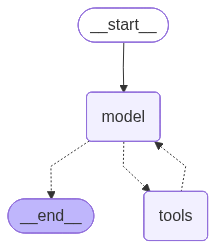

In [62]:
from langchain.agents import create_agent#, AgentExecutor

agent = create_agent(llm, tools) # primero inicializamos el agente ReAct
agent

Finalmente, probamos nuestro agente:

In [ ]:
response = agent.invoke(
    {"messages": [{"role": "user", "content": "qué equipo ganó el mundial de LoL 2024?"}]}
)

{'messages': [HumanMessage(content='qué equipo ganó el mundial de LoL 2024?', additional_kwargs={}, response_metadata={}, id='5a76f98f-7c1d-4c40-922d-a4fd0e4ad238'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "who won the LoL world championship 2024"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--36e74df4-1571-4e9b-836a-0117b485e1f4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'who won the LoL world championship 2024'}, 'id': '6d1c3b31-d979-4fbb-b8bd-dd1547ac7257', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 20, 'total_tokens': 82, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='[{"title": "2024 League of Legends World Championship - Wikipedia"

In [72]:
response["messages"][0]

HumanMessage(content='qué equipo ganó el mundial de LoL 2024?', additional_kwargs={}, response_metadata={}, id='5a76f98f-7c1d-4c40-922d-a4fd0e4ad238')

In [89]:
import json
print(json.dumps(dict(response["messages"][3]), indent=4, ensure_ascii=False).encode("utf8").decode())

{
    "content": "T1 ganó el Campeonato Mundial de League of Legends 2024.",
    "additional_kwargs": {},
    "response_metadata": {
        "prompt_feedback": {
            "block_reason": 0,
            "safety_ratings": []
        },
        "finish_reason": "STOP",
        "model_name": "gemini-2.0-flash",
        "safety_ratings": [],
        "grounding_metadata": {},
        "model_provider": "google_genai"
    },
    "type": "ai",
    "name": null,
    "id": "lc_run--8b368d6f-f72b-4be3-8e07-db90debfe27b-0",
    "tool_calls": [],
    "invalid_tool_calls": [],
    "usage_metadata": {
        "input_tokens": 505,
        "output_tokens": 16,
        "total_tokens": 521,
        "input_token_details": {
            "cache_read": 0
        }
    }
}


In [91]:
print(response["messages"][-1].content)

T1 ganó el Campeonato Mundial de League of Legends 2024.


### **Implementando nuestras propias tools**

Algo interesante que podemos hacer es **programar nuestras propias tools** para que el agente interactúe con ellas.

Revisemos un ejemplo en que programos tools con algunas **operaciones matemáticas**:

<center>
<img src='https://media1.tenor.com/images/dfe0c1c6eaf41b91996aacee0879ebc2/tenor.gif?itemid=3486402' width=400  />
</center>

In [92]:
from langchain.tools import tool

@tool
def multiply(x: int or float, y: int or float) -> float:
    """Multiply 'x' times 'y'."""
    return float(x * y)

@tool
def exponentiate(x: int or float, y: int or float) -> float:
    """Raise 'x' to the 'y'."""
    return float(x**y)

@tool
def add(x: int or float, y: int or float) -> float:
    """Add 'x' and 'y'."""
    return float(x + y)

Luego, simplemente agrupamos las tools en una lista:

In [93]:
tools = [add, multiply, exponentiate]

En paralelo, crearemos un **prompt** para nuestro agente:

In [98]:
# noten como ahora se incluye la variable agent_scratchpad
math_template = """
Eres un asistente experto en matemáticas.
Tu único rol es responder la pregunta del usuario usando las tools disponibles.

Pregunta: {input}
{agent_scratchpad}
"""

Con el prompt creado, pasamos a **crear nuestro agente**.

Noten que como nuestras tools reciben más de un parámetro de entrada (a y b), **remplazaremos ReAct por [Tool Calling](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/)** (de igual manera, pueden encontrar todos los tipos de Agentes disponibles y sus limitantes en el siguiente [link](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/)):

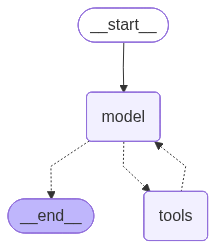

In [99]:

math_agent = create_agent(llm, tools, system_prompt=math_template)
math_agent

Finalmente, podemos probar el funcionamiento de nuestro agente:

In [101]:
response = math_agent.invoke({"messages": [{"role": "user", "content": "cuanto es 10 ** 3 + 5 * 1.4?"}]})
print(response["messages"][-1].content)

10 ** 3 = 1000
5 * 1.4 = 5 * (1 + 0.4) = 5 * 1 + 5 * 0.4 = 5 + 2 = 7
1000 + 7 = 1007

Respuesta: 1007


## **Soluciones Multi Agente 👨‍👩‍👦‍👦**

<center>
<img src='https://media.tenor.com/FApRE_u99tgAAAAC/teamwork-team-game.gif' width=400  />
</center>

En las secciones pasadas habilitamos agentes que puedan hacer RAG sobre fuentes externas:

- Una **chain** que responde preguntas de las últimas elecciones municipales en base a un informe en PDF
- Un **agente** que responde preguntas matemáticas a partir de tools creadas manualmente.

Con esto en consideración, nace la pregunta natural: **¿Qué pasa si combinamos ambas soluciones?**

El objetivo de esta sección es introducirlos al paradigma **multiagente**, es decir, **combinar 2 o más funcionalidades en un mismo chat**. En particular, buscaremos implementar una arquitectura simple de enrutamiento, la cual consta de 4 agentes:

- **Agente router**, el cual recibe y dirige la pregunta del usuario a alguno de los agentes.
- **Agente de elecciones**: responde preguntas sobre las elecciones municipales 2024
- **Agente experto en matemáticas**: responde preguntas matemáticas
- **Agente de redireccionamiento**: en caso de que la pregunta del usuario no pertenezca a alguno de los temas anteriores, invita al usuario a reorientar su pregunta (esto es útil para evitar preguntas maliciosas).

**Nota**: Para efectos de esta sección y por simplicidad, no se hace distinción entre Agente y Chain.

<center>
<img src='https://preview.redd.it/smart-orchestrator-router-for-multiple-specialized-llms-v0-gjgkmlbu3jlc1.png?width=627&format=png&auto=webp&s=13ef701d45f642ce36ae8e99cb172b903fe7d36b' width=600  />
</center>

De estos componentes, ya tenemos el agente de elecciones y el experto en matemáticas, y el de redireccionamiento es una simple chain. Sólo nos quedaría el **router**, el cual en base a la pregunta del usuario decidirá a cual de los 3 agentes ir. Para esto, el programa deberá tomar una decisión en base al output del LLM.

Sin embargo, los llm por defecto tienen salidas variantes. Incluso si se le da la instrucción específica de que solo puede responder una de 3 posibles opciones, el LLM podría introducir pequeñas variaciones o responder en una frase más larga. Incluso si el modelo es avanzado y se le da instrucciones muy estrictas, puede fallar. Para esto, haremos el uso de **output parsers**


**Importante: La implementación es sólo ilustrativa y <u>no cumple con el estándar actual recomendado por LangChain</u>. Si desean conocer mejor cómo implementar soluciones multiagente, les recomiendo estudiar [LangGraph](https://www.langchain.com/langgraph)**.

#### **Output parser**

Hasta ahora hemos visto ```StrOutputParser``` que simplemente transforma la salida del LLM en un objeto string. Sin embargo, una de las mejores características de langchain es que permite establecer un formato de salida muy específico donde _se asegura_ que se obtendrá en ese formato. Para esto, se apoyan de la lógica de **pydantic**, que es una librería ampliamente usada en python para hacer _type checking_ de variables.

> ***¿Pero como se setea esto en un modelo de lenguaje? ¿Qué clase de magia es esta?*** 
>
> Los output parsers logran esto envolviendo el prompt en instrucciones específicas con buenas prácticas de prompt al mismo tiempo que validan y corrigen la salida mediante un mecanismo de retry. En casos de que el modelo lo soporte, incluyen parámetros en la llamada al LLM lo cual activa meanismos internos adicionales para lograr esto. De esta forma, técnicamente no es 100% seguro que de el formato correcto, pero en la práctica se observará el 100% de las veces.

In [103]:
from pydantic import BaseModel, Field
from typing import Literal

class QuestionRoute(BaseModel):
    decision: Literal["elecciones", "math", "otro"] = Field(
        description="""
        Decisión sobre el agente más relevante para responder una pregunta.
        - 'elecciones': Cuando la pregunta se relacione específicamente con las elecciones municipales de chile 2024.
        - 'math': Cuando la pregunta sea relacionada a preguntas de matemáticas
        - 'otro': Todo aquella pregunta que no esté contenida en las categorías anteriores.
        """)

#### **Agente Router**

Primero comenzamos creando nuestro agente router:

In [105]:
router_prompt = PromptTemplate.from_template(
    """
    Eres un asistente experto en la clasificación de preguntas del usuario.
    Tu único rol es clasificar preguntas del usuario en las categorías 'elecciones', 'math', u 'otro'

    No respondas con más de una palabra y no incluyas.

    <pregunta>
    {question}
    </pregunta>

    Categoría:"""
)

structured_model = llm.with_structured_output(QuestionRoute)

router_chain = (
    router_prompt
    | structured_model
)

In [106]:
router_chain.invoke({"question": "cuanto es 2+2"})

QuestionRoute(decision='math')

In [107]:
router_chain.invoke({"question": "Qué partido sacó más votos en chile el 2024?"})

QuestionRoute(decision='elecciones')

In [108]:
router_chain.invoke({"question": "Qué alcalde ganó en nueva york el 2025?"})

QuestionRoute(decision='otro')

In [109]:
router_chain.invoke({"question": "Qué partido sacó más votos?"})

QuestionRoute(decision='elecciones')

#### **Agente Redirect**

Repetimos lo mismo para crear nuestro agente de redireccionamiento:

In [110]:
redirect_prompt = PromptTemplate.from_template(
    """
    Eres un asistente experto en el redireccionamiento de preguntas de usuarios.
    Vas a recibir una pregunta del usuario, tu único rol es indicar que no puedes responder su pregunta y redireccionar al usuario
    para que te pregunte sobre las elecciones municipales de Chile 2024 o cálculos matemáticos.

    Recuerda ser amable y cordial en tu respuesta.

    Pregunta: {question}
    Respuesta cordial:"""
)

redirect_chain = (
    redirect_prompt
    | llm
    | StrOutputParser()
)

redirect_chain.invoke({"question": "dame la receta para hacer una pizza"})

'Lamento mucho, pero no puedo ayudarte con recetas de cocina. Sin embargo, si tienes preguntas sobre las elecciones municipales de Chile 2024 o necesitas ayuda con cálculos matemáticos, ¡estaré encantado de asistirte!'

#### **Juntando todo**

Finalmente, podemos juntar todo lo que hemos desarrollado en una sola función:

In [132]:
def route_question(question):
  '''
  Recibe una pregunta de usuario.
  Rutea la pregunta al agente respectivo y responde de manera acorde.
  '''

  router_response = router_chain.invoke({"question": question}) # enrutamiento

  if "elecciones" in router_response.decision: # si la pregunta es sobre las elecciones, utilizar cadena
      return rag_chain.invoke(question)
  elif "math" in router_response.decision: # si la pregunta es de matemáticas, utilizar agente
      agent_input = {"messages": [{"role": "user", "content": question}]}
      return math_agent.invoke(agent_input)["messages"][-1].content
  else: # de lo contrario, redireccionar pregunta
      return redirect_chain.invoke({"question": question})

Para finalmente hacer pruebas de su funcionamiento:

In [133]:
print(route_question("cómo puedo hacerme millonario?"))

Lamento mucho, pero no puedo ofrecerte consejos sobre cómo hacerte millonario. Sin embargo, si tienes preguntas sobre las elecciones municipales de Chile 2024 o necesitas ayuda con algún cálculo matemático, ¡estaré encantado de ayudarte!


In [134]:
print(route_question("como fue la participación de las elecciones?"))

La participación en las elecciones fue alta en comparación con elecciones anteriores bajo el sistema de voto voluntario. Incluso, fue levemente superior a eventos recientes con voto obligatorio, consolidando la efectividad de estas medidas en aumentar la participación electoral.


In [135]:
print(route_question("cuanto es 5+3?"))

5+3 es 8.
